In [68]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [69]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette, get_models_dir
from nlinec.data.preprocessing import get_granularity

## Parameters

In [70]:
granularities = ['Coarse', 'Medium', 'Fine']

In [71]:
models = os.listdir(get_models_dir())
print(models)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3']


In [72]:
# Specify the dataset to predict and a file to load the predictions from
SPLIT = "test"
DATASET = f'g_{SPLIT}.json'

MODEL_BASE = "roberta-large-mnli"
MODEL_FINETUNED = "nlinec-D-2"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODEL_FINETUNED_TO = os.path.join(get_models_dir(), MODEL_FINETUNED)
SAVE_PREDICTIONS_BASE_TO = os.path.join(get_results_dir(), MODEL_BASE, f"{SPLIT}_predictions.csv")
SAVE_PREDICTIONS_FINETUNED_TO = os.path.join(get_results_dir(), MODEL_FINETUNED, f"{SPLIT}_predictions.csv")

SAVE_PREDICTIONS_BASE_TO_HO = os.path.join(get_results_dir(), MODEL_BASE, f"{SPLIT}_predictions_ho.csv")
SAVE_PREDICTIONS_FINETUNED_TO_HO = os.path.join(get_results_dir(), MODEL_FINETUNED, f"{SPLIT}_predictions_ho.csv")

## Setup 

In [73]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 102549.02it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [74]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [75]:
def load_predictions(path):
    # Get the predictions
    predictions_df = pd.read_csv(path, index_col=0)

    # Combine the predictions with the original data based on the index
    data_with_predictions = positive_data.join(predictions_df).explode('full_type')

    # Add the granularity of the type
    data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

    # Reset the index
    data_with_predictions.reset_index(drop=True, inplace=True)

    # Compute the predicted type for each granularity
    for i in [1, 2, 3]:
        # Get the rows where the correct type has the correct granularity
        granularity_mask = data_with_predictions['granularity'] == i

        # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
        data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)
        
        # Add a column that stores if the prediction was correct
        data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']
        
        # Add a new column which stores the probability of the correct type
        data_with_predictions.loc[granularity_mask, 'predicted_type_probability'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].max(axis=1)

    for i in [1, 2, 3]:
        # Get the ground truth type at the current granularity
        data_with_predictions[f'type_{i}'] = data_with_predictions['full_type'].apply(lambda x: get_type(x, granularity=i))

        # # Get the predicted type at the current granularity
        data_with_predictions[f'predicted_type_{i}'] = data_with_predictions['predicted_type'].apply(lambda x: get_type(x, granularity=i))

        # # Get the probability of the predicted type at the current granularity
        data_with_predictions[f'predicted_type_{i}_probability'] = data_with_predictions.apply(lambda row: row.get(get_type(row['predicted_type'], include_path=True, granularity=i)), axis=1)

    return data_with_predictions

In [76]:
base_predictions = load_predictions(SAVE_PREDICTIONS_BASE_TO)
finetuned_predictions = load_predictions(SAVE_PREDICTIONS_FINETUNED_TO)

base_predictions_ho = load_predictions(SAVE_PREDICTIONS_BASE_TO_HO)
finetuned_predictions_ho = load_predictions(SAVE_PREDICTIONS_FINETUNED_TO_HO)

In [77]:
improvement_df = pd.DataFrame(columns=['improved'])

improvement_df['improved'] = finetuned_predictions['correct'] & ~base_predictions['correct']
improvement_df['gained_confidence'] = finetuned_predictions['predicted_type_probability'] - base_predictions['predicted_type_probability']

# Find out for which instance the confidence increased the most
improvement_df[improvement_df['improved'] & (base_predictions['granularity'] == 2)].sort_values(by='gained_confidence', ascending=False).head(10)

,improved,gained_confidence
12184,True,0.952418
12140,True,0.945379
12102,True,0.829260
5694,True,0.761466
1212,True,0.746676
12219,True,0.726272
397,True,0.722753
3958,True,0.716778
7260,True,0.699741
2790,True,0.698932


In [78]:
print(base_predictions.loc[8283, ['sentence']].values[0])
base_predictions.loc[8283, ['sentence', 'mention_span', 'predicted_type', 'full_type', 'predicted_type_probability']]

In addition, Gulf must give the government 20 days ' advance written notice of any loans exceeding $ 50 million that are made to the Bermuda - based holding company.


sentence                      In addition, Gulf must give the government 20 ...
mention_span                                                     the government
predicted_type                                              /other/living_thing
full_type                                              /organization/government
predicted_type_probability                                             0.311407
Name: 8283, dtype: object

### Ferret

In [79]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ferret import Benchmark
from nlinec.data.preprocessing import combine_premise_hypothesis, construct_hypothesis

In [80]:
base_model = AutoModelForSequenceClassification.from_pretrained('roberta-large-mnli').to(DEVICE)
finetuned_model = AutoModelForSequenceClassification.from_pretrained(SAVE_MODEL_FINETUNED_TO).to(DEVICE)
    
tokenizer = AutoTokenizer.from_pretrained('roberta-large-mnli')

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
base_bench = Benchmark(base_model, tokenizer)
finetuned_bench = Benchmark(finetuned_model, tokenizer)

In [82]:
def get_benchmark(index, granularity, bench, type_):
    if base_predictions.loc[index, f'type_{granularity}'] is None:
        raise ValueError(f'No {granularity}-grained type for this example')

    combined_input = combine_premise_hypothesis(
        base_predictions.loc[index, 'sentence'],
        construct_hypothesis(base_predictions.loc[index, 'mention_span'], type_)
    )

    explanations = bench.explain(combined_input, target=int(base_predictions.loc[index, 'label']))
    evaluations = bench.evaluate_explanations(explanations, int(base_predictions.loc[index, 'label']))

    eval_table = bench.show_evaluation_table(evaluations)

    explanation_table = bench.show_table(explanations)
    explanation_table.__dict__['data'].columns = [column.replace('Ġ', '') for column in explanation_table.__dict__['data'].columns]
    
    return eval_table, explanation_table

In [83]:
def compare_benchmarks(base_bench, finetuned_bench, index, granularity, type_):
    _, explanation_table_base = get_benchmark(index, granularity, base_bench, type_)
    _, explanation_table_finetuned = get_benchmark(index, granularity, finetuned_bench, type_)

    explanation_table_list = [explanation_table_base, explanation_table_finetuned]

    fig, axes = plt.subplots(1, 2, figsize=(4, explanation_table_list[0].data.shape[1] // 5), dpi=200)
    fig.tight_layout(w_pad=5)

    column_selection = ['LIME', 'Integrated Gradient']
    column_selection_short = ['LIME', 'IG']

    # Compute the minimum and maximum value of the explanation tables
    min_value = min([table.data.loc[column_selection].values.min() for table in explanation_table_list])
    max_value = max([table.data.loc[column_selection].values.max() for table in explanation_table_list])

    if type(axes) not in [np.ndarray, list]:
        axes = [axes]

    for ax, table, model in zip(axes, explanation_table_list, ['roberta-large-mnli', 'nlinec-B-2']):
        # Draw a pcolormesh of the explanation table
        ax.pcolormesh(table.data.loc[column_selection].T.round(2),
                        cmap=mcolors.LinearSegmentedColormap.from_list("", ['#65BBF0', color_palette('bright'), color_palette('accent')]),
                        vmin=min_value, vmax=max_value)

        # Draw a horizontal line where the hypothesis starts (i.e. at between the </s> and <s> tokens)
        ax.axhline(table.data.columns.get_loc('<s>'), color='black', linewidth=1)

        # Invert the y-axis and set the tick labels to the column names (word pieces)
        ax.invert_yaxis()
        ax.set_yticks(np.arange(len(table.data.columns)) + 0.5)

        # Set the x-axis tick labels to the row names (Explainers) and show them on top of the plot
        ax.set_xticks(np.arange(len(column_selection)) + 0.5)
        ax.set_xticklabels(column_selection_short);
        ax.xaxis.tick_top()

        # Show the model name as title below the plot
        ax.set_title(model, y=-0.05) 

    # Create a new axis at the bottom of the figure for the colorbar
    cax = fig.add_axes([0.1, 0.05, 0.8, 0.05])
    cbar = fig.colorbar(axes[0].collections[0], cax=cax, orientation='horizontal', pad=0.05, aspect=10)

    axes[1].set_yticklabels([])

    # Show the yticks on the right for axis 0
    axes[0].yaxis.tick_right()
    axes[0].set_yticklabels(table.data.columns)


    # Add a little space between the colorbar and the plots
    fig.subplots_adjust(bottom=0.16)

    return fig, axes

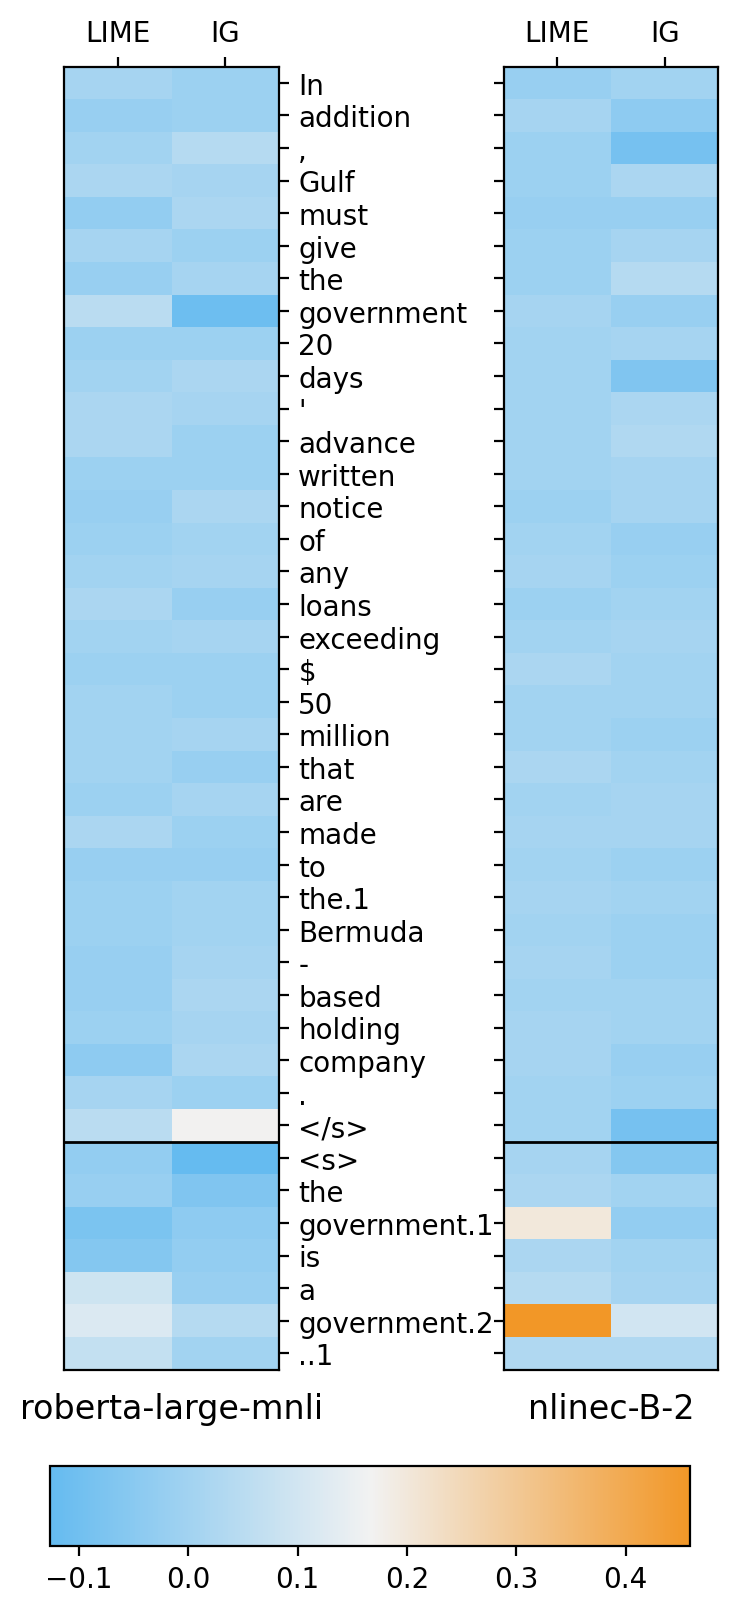

In [84]:
compare_benchmarks(base_bench, finetuned_bench, index=8283, granularity=2, type_='government');

- Focus shifts towards the tokens that represent the type in question
- Neither model cares much about the premise

In [85]:
# Find an instance where the hypothesis only prediction of the fine-tuned model is wrong and the full prediction is correct
ho_df = pd.DataFrame()

ho_df['premise_helpful'] = ~finetuned_predictions_ho['correct'] & finetuned_predictions['correct']
ho_df['premise_misleading'] = finetuned_predictions_ho['correct'] & ~finetuned_predictions['correct']

In [86]:
ho_df[finetuned_predictions['granularity'] == 2].sort_values(by='premise_helpful', ascending=False).head(10)

,premise_helpful,premise_misleading
7115,True,False
2058,True,False
11626,True,False
11617,True,False
8244,True,False
8246,True,False
8258,True,False
5369,True,False
5366,True,False
8260,True,False


In [88]:
print(finetuned_predictions_ho.loc[11626, ['sentence']].values[0])
finetuned_predictions_ho.loc[11626, ['sentence', 'mention_span', 'predicted_type', 'full_type', 'predicted_type_probability']]

What makes Mao - tai even more famous is that first generation leaders of new China had used it to entertain distinguished guests such as former president Nixon of the US, Tanaka Kakuei , former prime minister of Japan , etc.


sentence                      What makes Mao - tai even more famous is that ...
mention_span                     Tanaka Kakuei , former prime minister of Japan
predicted_type                                                /location/country
full_type                                              /person/political_figure
predicted_type_probability                                             0.974265
Name: 11626, dtype: object

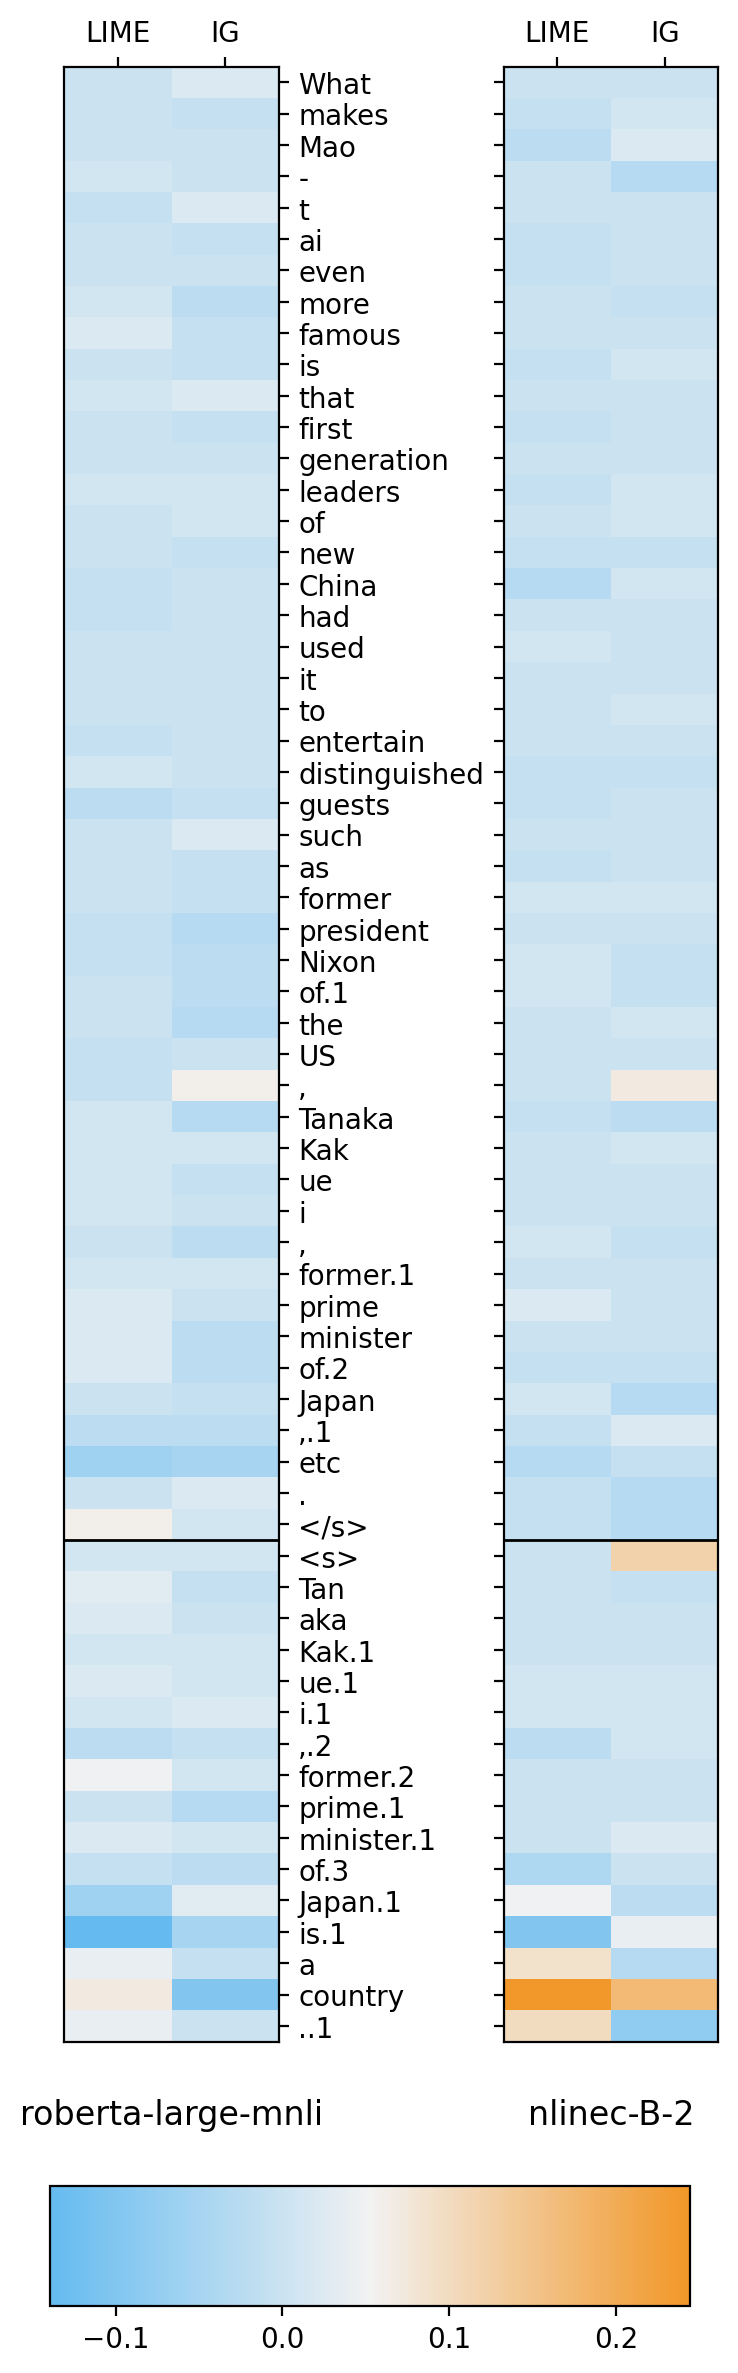

In [44]:
compare_benchmarks(base_bench, finetuned_bench, index=11626, granularity=2, type_='country');

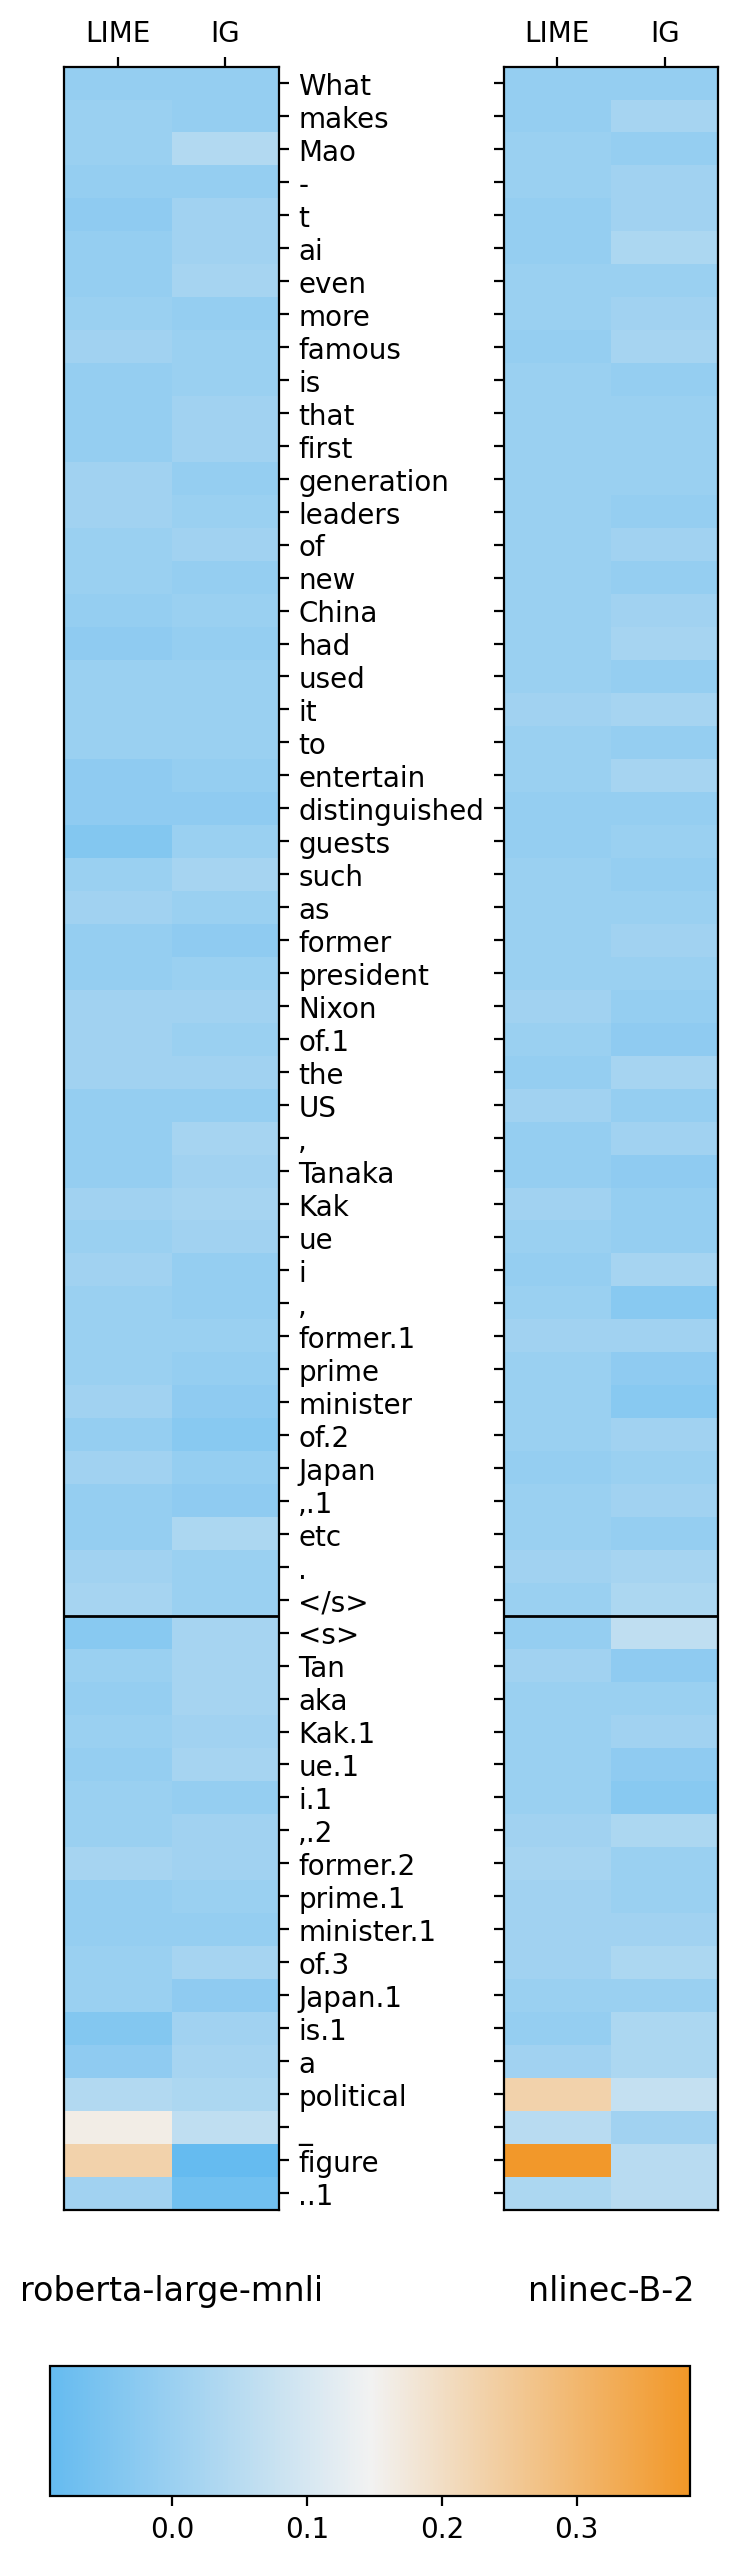

In [ ]:
compare_benchmarks(base_bench, finetuned_bench, index=11626, granularity=2, type_='political_figure');

In [100]:
ho_df[finetuned_predictions['granularity'] == 2].sort_values(by='premise_misleading', ascending=False).head(20)

,premise_helpful,premise_misleading
8051,False,True
8924,False,True
6157,False,True
10315,False,True
1539,False,True
3729,False,True
12855,False,True
1990,False,True
8926,False,True
833,False,True


In [103]:
print(finetuned_predictions.loc[3777, ['sentence']].values[0])
finetuned_predictions.loc[3777, ['sentence', 'mention_span', 'predicted_type', 'full_type', 'predicted_type_probability']]

Thus, when Mr. Pierce asserted the Fifth in a noncriminal proceeding, particularly after presumably receiving extensive advice from legal counsel , one must conclude that he held a good - faith, justifiable belief that his testimony could be used against him in a subsequent criminal prosecution.


sentence                      Thus, when Mr. Pierce asserted the Fifth in a ...
mention_span                                                      legal counsel
predicted_type                                                    /person/title
full_type                                                         /person/legal
predicted_type_probability                                             0.986091
Name: 3777, dtype: object